# Análise de Dados de Membros de Academia e Modelos de Previsão

Neste notebook, realizaremos várias análises preditivas sobre dados de membros de academia. Os seguintes modelos preditivos serão desenvolvidos:

1. **Previsão de Churn**: Prever quais membros provavelmente cancelarão suas inscrições.
2. **Previsão de Satisfação**: Prever as pontuações de satisfação dos membros com base em vários fatores.
3. **Previsão de Demanda por Classes/Atividades**: Prever a frequência para diferentes aulas.
4. **Análise de Segmentação**: Identificar grupos distintos de membros da academia usando técnicas de agrupamento.
5. **Sistema de Recomendação de Exercícios**: Sugerir exercícios para os membros com base em suas preferências.
6. **Previsão de Gasto Calórico**: Prever as calorias queimadas durante um treino.

Seguiremos as práticas recomendadas de aprendizado de máquina, incluindo pré-processamento de dados, divisão do conjunto de dados em conjuntos de treinamento e teste, e avaliação do desempenho do modelo.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import (
  RandomForestClassifier,
  RandomForestRegressor,
)

# Para modelos
from sklearn.linear_model import (
  LinearRegression,
)

# Para avaliação
from sklearn.metrics import (
  accuracy_score,
  classification_report,
  mean_squared_error,
  r2_score,
)

# Para seleção de modelo
from sklearn.model_selection import (
  train_test_split,
)
from sklearn.neighbors import NearestNeighbors

# Para pré-processamento
from sklearn.preprocessing import (
  LabelEncoder,
  StandardScaler,
)

In [2]:
# Carregar os dados
data = pd.read_csv("./data/fitness_gym.csv")

# Exibir as primeiras linhas
data.head()

,check_in_id,date,time,member_id,age,gender,membership_type,activity,duration_minutes,calories_burned,activity_category,attendance_streak,satisfaction_score,cancelled,cancellation_reason
0,CHECK_0001,2023-01-01,07:16:00,MEMBER_0054,56,F,Basic,Yoga,50,162,Bem-estar,5,4,False,NaN
1,CHECK_0002,2023-01-02,18:47:00,MEMBER_0021,18,F,Premium,CrossFit,64,633,Funcional,22,5,False,NaN
2,CHECK_0003,2023-01-04,07:54:00,MEMBER_0072,36,M,Premium,Musculação,73,417,Força,16,5,False,NaN
3,CHECK_0004,2023-01-08,12:10:00,MEMBER_0016,19,F,Basic,Jump,41,360,Cardio,11,4,False,NaN
4,CHECK_0005,2023-01-12,08:14:00,MEMBER_0059,26,M,Basic,Musculação,81,462,Força,9,5,False,NaN


In [3]:
# Codificação por Etiquetas para variáveis categóricas binárias
label_encoder = LabelEncoder()
data["gender"] = label_encoder.fit_transform(
  data["gender"]
)

data = pd.get_dummies(
  data,
  columns=["activity_category"],
  drop_first=True,
)

# Identificar variáveis categóricas
categorical_cols = [
  "membership_type",
  "activity",
  "cancellation_reason",
]

# Criar dummies
dummies = pd.get_dummies(data[categorical_cols])

# Concatenar as dummies de volta ao DataFrame original
data = pd.concat([data, dummies], axis=1)

In [4]:
# Características que podem necessitar de escalonamento
numerical_cols = [
  "age",
  "duration_minutes",
  "calories_burned",
  "attendance_streak",
  "satisfaction_score",
]

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(
  data[numerical_cols]
)

In [5]:
# Definir uma função para dividir dados
def split_data(
  X, y, test_size=0.2, random_state=42
):
  return train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state,
  )

In [6]:
# Previsão de Churn

# Características e variável alvo
X_churn = data[
  ["satisfaction_score", "attendance_streak"]
  + [
    col
    for col in data.columns
    if "membership_type_" in col
  ]
]
y_churn = data["cancelled"]

# Dividir os dados
X_train, X_test, y_train, y_test = split_data(
  X_churn, y_churn
)

# Construir o modelo
model_churn = RandomForestClassifier(
  random_state=42
)
model_churn.fit(X_train, y_train)

# Previsões
y_pred = model_churn.predict(X_test)

# Avaliação
print("Acurácia:", accuracy_score(y_test, y_pred))
print(
  "\nRelatório de Classificação:\n",
  classification_report(
    y_test, y_pred, zero_division=1
  ),
)

Acurácia: 0.8

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.84      0.94      0.89        34
        True       0.00      0.00      0.00         6

    accuracy                           0.80        40
   macro avg       0.42      0.47      0.44        40
weighted avg       0.72      0.80      0.76        40



In [7]:
# Previsão de Satisfação

# Características e variável alvo
X_sat = data[
  [
    "duration_minutes",
    "calories_burned",
    "attendance_streak",
  ]
  + [
    col
    for col in data.columns
    if "activity_" in col
    or "activity_category_" in col
  ]
]
y_sat = data["satisfaction_score"]

# Dividir os dados
X_train, X_test, y_train, y_test = split_data(
  X_sat, y_sat
)

# Construir o modelo
model_sat = LinearRegression()
model_sat.fit(X_train, y_train)

# Previsões
y_pred = model_sat.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Quadrático Médio:", mse)
print("Pontuação R^2:", r2)

Erro Quadrático Médio: 0.9534304820110082
Pontuação R^2: -0.2139315807618578


In [8]:
# Previsão de Demanda por Classes/Atividades

# Criar um novo DataFrame para frequência
attendance_data = (
  data.groupby(["activity", "date", "time"])
  .size()
  .reset_index(name="attendance_count")
)

# Converter 'date' e 'time' para datetime
attendance_data["datetime"] = pd.to_datetime(
  attendance_data["date"]
  + " "
  + attendance_data["time"]
)

# Características e variável alvo
X_demand = pd.get_dummies(
  attendance_data[["activity"]], drop_first=True
)
X_demand["hour"] = attendance_data[
  "datetime"
].dt.hour
y_demand = attendance_data["attendance_count"]

# Dividir os dados
X_train, X_test, y_train, y_test = split_data(
  X_demand, y_demand
)

# Construir o modelo
model_demand = RandomForestRegressor(
  random_state=42
)
model_demand.fit(X_train, y_train)

# Previsões
y_pred = model_demand.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Quadrático Médio:", mse)
print("Pontuação R^2:", r2)

Erro Quadrático Médio: 0.0
Pontuação R^2: 1.0


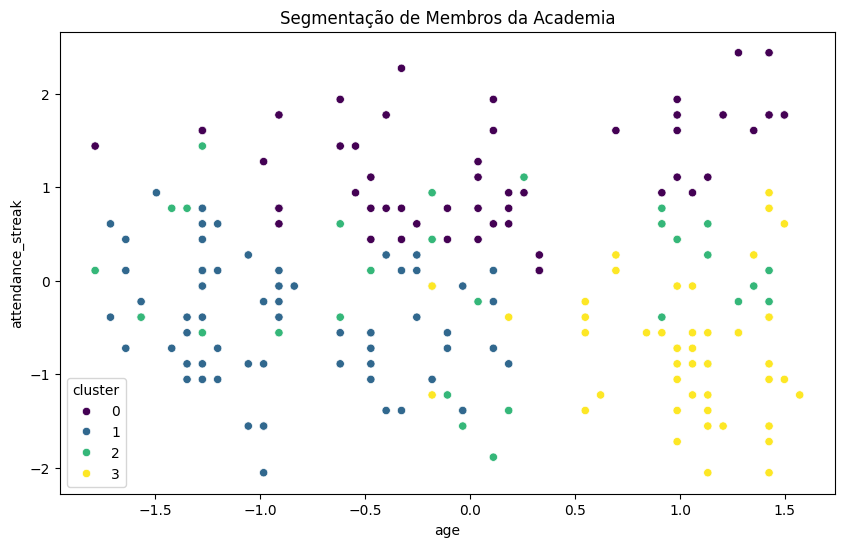

In [9]:
# Análise de Segmentação

# Características para agrupamento
X_segmentation = data[
  ["age", "gender", "attendance_streak"]
  + [
    col
    for col in data.columns
    if "activity_" in col
  ]
]

# Construir o modelo
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_segmentation)

# Adicionar rótulos de cluster aos dados
data["cluster"] = clusters

# Visualizar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
  x="age",
  y="attendance_streak",
  hue="cluster",
  data=data,
  palette="viridis",
)
plt.title("Segmentação de Membros da Academia")
plt.show()

In [10]:
# Sistema de Recomendação de Exercícios

# Características para recomendação
X_recommend = data[
  ["duration_minutes", "calories_burned"]
  + [
    col
    for col in data.columns
    if "activity_" in col
  ]
]

# Construir o modelo
nn = NearestNeighbors(
  n_neighbors=5, algorithm="ball_tree"
)
nn.fit(X_recommend)


# Função para recomendar exercícios
def recommend_workouts(member_id):
  member_data = data[
    data["member_id"] == member_id
  ]
  if member_data.empty:
    print("Membro não encontrado.")
    return
  distances, indices = nn.kneighbors(
    member_data[X_recommend.columns]
  )
  recommended_indices = indices[0][
    1:
  ]  # Excluir o primeiro (ele mesmo)
  recommendations = data.iloc[
    recommended_indices
  ]["activity"].unique()
  print(
    f"Exercícios recomendados para {member_id}: {', '.join(recommendations)}"
  )


# Uso de exemplo
recommend_workouts("MEMBER_0054")

Exercícios recomendados para MEMBER_0054: Yoga


In [11]:
# Previsão de Gasto Calórico

# Características e variável alvo
X_calorie = data[
  ["duration_minutes", "age", "gender"]
  + [
    col
    for col in data.columns
    if "activity_" in col
    or "membership_type_" in col
  ]
]
y_calorie = data["calories_burned"]

# Dividir os dados
X_train, X_test, y_train, y_test = split_data(
  X_calorie, y_calorie
)

# Construir o modelo
model_calorie = LinearRegression()
model_calorie.fit(X_train, y_train)

# Previsões
y_pred = model_calorie.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erro Quadrático Médio:", mse)
print("Pontuação R^2:", r2)

Erro Quadrático Médio: 0.032006158752902344
Pontuação R^2: 0.9493913371362376
